### Importing the Libraries

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing import image
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from string import ascii_uppercase

In [45]:
tf.__version__ 

'2.13.0'

### Part 1 - Data Preprocessing

#### Generating images for the Training set

In [39]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#### Generating images for the Test set

In [6]:
test_datagen = ImageDataGenerator(rescale = 1./255)

### Creating the Training set

In [40]:
training_set = train_datagen.flow_from_directory('../dataSet/trainingData/',                                
                                                 target_size = (128, 128),
                                                 batch_size = 10,
                                                 color_mode = 'grayscale',                                
                                                 class_mode = 'categorical')

Found 1350 images belonging to 27 classes.


In [7]:
test_set = test_datagen.flow_from_directory('../dataSet/testingData/',
                                            target_size = (128, 128),                                  
                                            batch_size = 10,        
                                            color_mode = 'grayscale',
                                            class_mode = 'categorical')

Found 270 images belonging to 27 classes.


### Part 2 - Building the CNN

#### Initializing the CNN

In [50]:
classifier = tf.keras.models.Sequential()

#### Step 1 - Convolution

In [51]:
classifier.add(tf.keras.layers.Conv2D(filters=32,
                                     kernel_size=3, 
                                     padding="same", 
                                     activation="relu", 
                                     input_shape=[128, 128, 1]))

#### Step 2 - Pooling

In [52]:
classifier.add(tf.keras.layers.MaxPool2D(pool_size=2, 
                                         strides=2, 
                                         padding='valid'))

#### Adding a second convolutional layer

In [53]:
classifier.add(tf.keras.layers.Conv2D(filters=32, 
                                      kernel_size=3, 
                                      padding="same", 
                                      activation="relu"))

classifier.add(tf.keras.layers.MaxPool2D(pool_size=2, 
                                         strides=2, 
                                         padding='valid'))

#### Step 3 - Flattening

In [54]:
classifier.add(tf.keras.layers.Flatten())

#### Step 4 - Full Connection

In [55]:
classifier.add(tf.keras.layers.Dense(units=128, activation='relu'))
classifier.add(tf.keras.layers.Dropout(0.40))
classifier.add(tf.keras.layers.Dense(units=96, activation='relu'))
classifier.add(tf.keras.layers.Dropout(0.40))
classifier.add(tf.keras.layers.Dense(units=64, activation='relu'))
classifier.add(tf.keras.layers.Dense(units=27, activation='softmax')) # softmax for more than 2

### Part 3 - Training the CNN

#### Compiling the CNN

In [56]:
classifier.compile(optimizer = 'adam', 
                   loss = 'categorical_crossentropy', 
                   metrics = ['accuracy'])

#### Training the CNN on the Training set and evaluating it on the Test set

In [57]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_12 (Dense)            (None, 128)              

In [58]:
history = classifier.fit(training_set,
                  epochs = 10,
                  validation_data = test_set)

Epoch 1/10


135/135 [==============================] - 32s 227ms/step - loss: 3.3127 - accuracy: 0.0311 - val_loss: 3.2938 - val_accuracy: 0.0185
Epoch 2/10
135/135 [==============================] - 37s 277ms/step - loss: 3.2959 - accuracy: 0.0393 - val_loss: 3.2066 - val_accuracy: 0.1000
Epoch 3/10
135/135 [==============================] - 32s 235ms/step - loss: 2.8156 - accuracy: 0.1800 - val_loss: 1.1745 - val_accuracy: 0.6556
Epoch 4/10
135/135 [==============================] - 36s 267ms/step - loss: 1.5223 - accuracy: 0.5289 - val_loss: 0.2532 - val_accuracy: 0.9630
Epoch 5/10
135/135 [==============================] - 38s 281ms/step - loss: 0.9608 - accuracy: 0.7193 - val_loss: 0.1522 - val_accuracy: 0.9741
Epoch 6/10
135/135 [==============================] - 35s 261ms/step - loss: 0.6667 - accuracy: 0.8104 - val_loss: 0.0221 - val_accuracy: 0.9963
Epoch 7/10
135/135 [==============================] - 36s 265ms/step - loss: 0.4786 - accuracy: 0.8489 - val_loss: 0.0340 - val_accuracy: 0.9

Best Validation Loss: 0.0091
Best Validation Accuracy: 0.9963


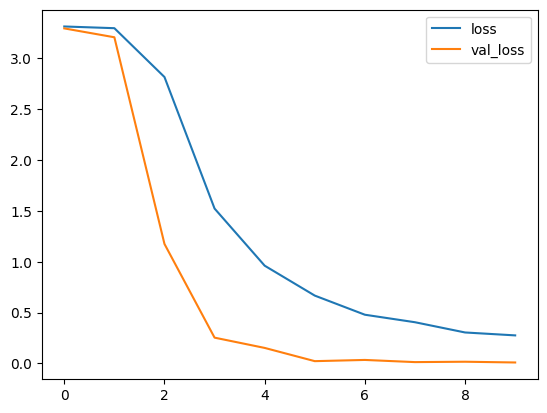

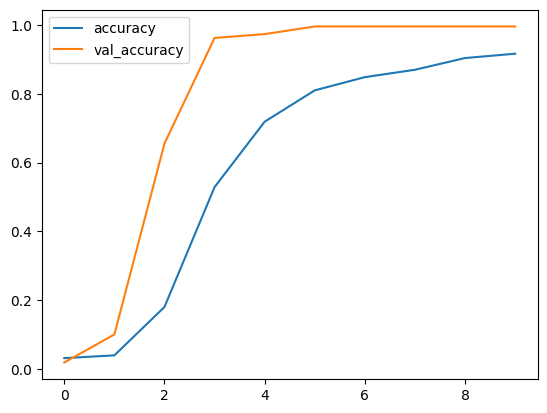

In [79]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

#### Saving the Model

In [ ]:
model_json = classifier.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
print('Model Saved')
classifier.save_weights('model.h5')
print('Weights saved')

Loading Model

In [3]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)

loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


Making predictions of test images using the Model

In [ ]:
num_batches = len(test_set)  # Get the total number of batches

all_predictions = []  # To store predictions for all batches
all_true_labels = []   # To store true labels for all batches

# Loop through all batches in the test data generator
for _ in range(num_batches):
    batch_images, batch_labels = next(test_set)  # Load batch images and labels

    # Make predictions on the batch of images
    batch_predictions = loaded_model.predict(batch_images)

    all_predictions.append(batch_predictions)
    all_true_labels.append(batch_labels)

# Concatenate predictions and true labels from all batches into arrays
all_predictions = np.concatenate(all_predictions, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

# Now 'all_predictions' contains predictions for all samples in your test set
# 'all_true_labels' contains the true labels for all samples in your test set

# Assuming your classes are one-hot encoded, get the predicted and actual classes
predicted_classes = np.argmax(all_predictions, axis=1)
actual_classes = np.argmax(all_true_labels, axis=1)


Printing predicted and actual class

In [9]:
alphabets = "0" + ascii_uppercase
count = 0

for i in range(len(predicted_classes)):
    if predicted_classes[i]==actual_classes[i]:
        count += 1

    print(f"Sample {i+1}: Predicted Class {alphabets[predicted_classes[i]]}, Actual Class {alphabets[actual_classes[i]]}")

print(f"Accuracy: {count/len(predicted_classes)}")

Sample 1: Predicted Class Q, Actual Class Q
Sample 2: Predicted Class C, Actual Class C
Sample 3: Predicted Class B, Actual Class B
Sample 4: Predicted Class H, Actual Class H
Sample 5: Predicted Class R, Actual Class R
Sample 6: Predicted Class J, Actual Class J
Sample 7: Predicted Class W, Actual Class W
Sample 8: Predicted Class G, Actual Class G
Sample 9: Predicted Class N, Actual Class N
Sample 10: Predicted Class P, Actual Class P
Sample 11: Predicted Class B, Actual Class B
Sample 12: Predicted Class L, Actual Class L
Sample 13: Predicted Class U, Actual Class U
Sample 14: Predicted Class C, Actual Class C
Sample 15: Predicted Class B, Actual Class B
Sample 16: Predicted Class L, Actual Class L
Sample 17: Predicted Class B, Actual Class B
Sample 18: Predicted Class F, Actual Class F
Sample 19: Predicted Class 0, Actual Class 0
Sample 20: Predicted Class L, Actual Class L
Sample 21: Predicted Class 0, Actual Class 0
Sample 22: Predicted Class P, Actual Class P
Sample 23: Predicte

Displaying the test image with the predicted and actual class

1/1 [==============================] - 0s 92ms/step


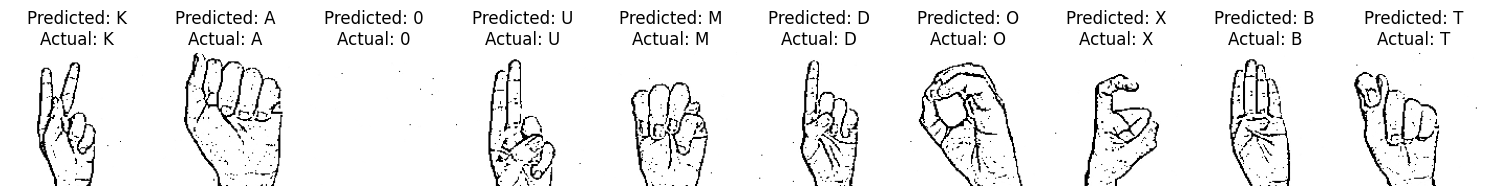

In [39]:
# Assuming test_set is your test data generator
num_batches = len(test_set)  # Get the total number of batches

# Loop through one of the batch in the test data generator
for _ in range(1):
    batch_images, batch_labels = next(test_set)  # Load batch images and labels

    # Make predictions on the batch of images
    batch_predictions = loaded_model.predict(batch_images)

    # Assuming your classes are one-hot encoded, get the predicted and actual classes
    predicted_classes = np.argmax(batch_predictions, axis=1)
    actual_classes = np.argmax(batch_labels, axis=1)

    # Create a grid of subplots
    fig, axes = plt.subplots(1, 10, figsize=(15, 5))

    # Loop through each image in the batch
    for i in range(10):
        # Display the image
        axes[i].imshow(batch_images[i].squeeze(), cmap='gray')  # Display the grayscale image
        axes[i].set_title(f"Predicted: {alphabets[predicted_classes[i]]}\nActual: {alphabets[actual_classes[i]]}")
        axes[i].axis('off')

    plt.tight_layout()  # Ensure subplots don't overlap
    plt.show()

In [41]:
alphabets = "0" + ascii_uppercase
count = 0

# Directory containing the images for prediction
image_directory = '../dataSet/Words/HELLO/'
image_files = os.listdir(image_directory)

# List to store predictions
predictions = []

# Loop through each image file in the directory
for image_file in image_files:
    img_path = os.path.join(image_directory, image_file)

    img = cv2.imread(img_path)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # blur = cv2.GaussianBlur(img,(5,5),2)
    # th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
    # ret, res = cv2.threshold(th3, 70, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    test_image = cv2.resize(gray, (128, 128))

    result = loaded_model.predict(test_image.reshape(1, 128, 128, 1))

    predicted_class_index = np.argmax(result)
    predictions.append(alphabets[predicted_class_index])


1/1 [==============================] - 0s 68ms/step


In [42]:
predictions

['H', 'E', 'L', 'L', 'O']